# Description

This notebook is almost identical to yield_prediction.ipynb. However, we predict yields on a dataset in which we swap 2018 rainfall with 2017 rainfall. The purpose is to estimate a counterfactual of what the treatment would have looked like if rainfall was at 2017 levels, which was roughly average.

# reNDVI

First try to predict raw reNDVI values in 2017, which may be more consistent across years since it doesn't depend on farmer recall. We will store results in the same dataframe for all outcome measures, and then save them as a CSV. A lot of code is redundant because it jsut gets copied and pasted from one measure to the next. 

## Data preparation and imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd 
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.ipython.ggplot import image_png

base = importr('base')
stats = importr('stats')
jtools = importr('jtools')

pandas2ri.activate()
pandas2ri.default_timezone = 'GMT'  # To avoid warning 

In [2]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

# Create dataframe to store predictions 
results = pd.DataFrame(index=raw_df.index)
results['uid'] = results.index.str[:-4]
results['year'] = pd.to_numeric(results.index.str[-4:])
results['treatment'] = raw_df['treatment']
results.loc[results['year'] == 2017, 'yield_hectare_2017'] = raw_df['yield_hectare_']
results['yield_hectare_2017'] = results.groupby(['uid'])['yield_hectare_2017'].ffill()
results.loc[results['year'] == 2017, 'sat_yield_2017'] = raw_df['satellite_yield_']
results['sat_yield_2017'] = results.groupby(['uid'])['sat_yield_2017'].ffill()
results.loc[results['year'] == 2017, 'max_re705_2016'] = raw_df['lag_re705_']
results['max_re705_2016'] = results.groupby(['uid'])['max_re705_2016'].ffill()
results.loc[results['year'] == 2018, 'max_re705_2017'] = raw_df['lag_re705_']
results['max_re705_2017'] = results.groupby(['uid'])['max_re705_2017'].bfill()

raw_df.drop(columns = ['yield_hectare_', 'satellite_yield_'], inplace=True)  # Just look at Red-edge NDVI values for now

raw_df.dropna(subset=['max_re705_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
# Full DF is what we later generate final predictions off of, so we replace 2018 rainfall with 2017 values
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)
full_df['uid'] = full_df.index.str[:-4]
full_df['year'] = pd.to_numeric(full_df.index.str[-4:])
full_df.loc[full_df['year'] == 2018, 'rain_june_'] = None 
full_df['rain_june_'] = full_df.groupby(['uid'])['rain_june_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_july_'] = None 
full_df['rain_july_'] = full_df.groupby(['uid'])['rain_july_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_august_'] = None 
full_df['rain_august_'] = full_df.groupby(['uid'])['rain_august_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_september_'] = None 
full_df['rain_september_'] = full_df.groupby(['uid'])['rain_september_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_october_'] = None 
full_df['rain_october_'] = full_df.groupby(['uid'])['rain_october_'].ffill()
full_df.drop(columns=['uid', 'year'], inplace=True)
# Since we don't have 2017 data for some plots, there will be missing rainfall. Drop these.
full_df.dropna(subset=['rain_june_'], inplace=True)

# Separate IVs and DVs
y = df[['max_re705_']]
X = df.drop(columns=['max_re705_'])
full_y = full_df[['max_re705_']]
full_X = full_df.drop(columns=['max_re705_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [3]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'max_re705_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['max_re705_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("max_re705")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [4]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 0.00031814
Optimal l1_ratio: 1.000
Number of iterations 10
Training R^2: 0.27625275210910116
Out of sample R^2: 0.25904678891224


### Feature importance

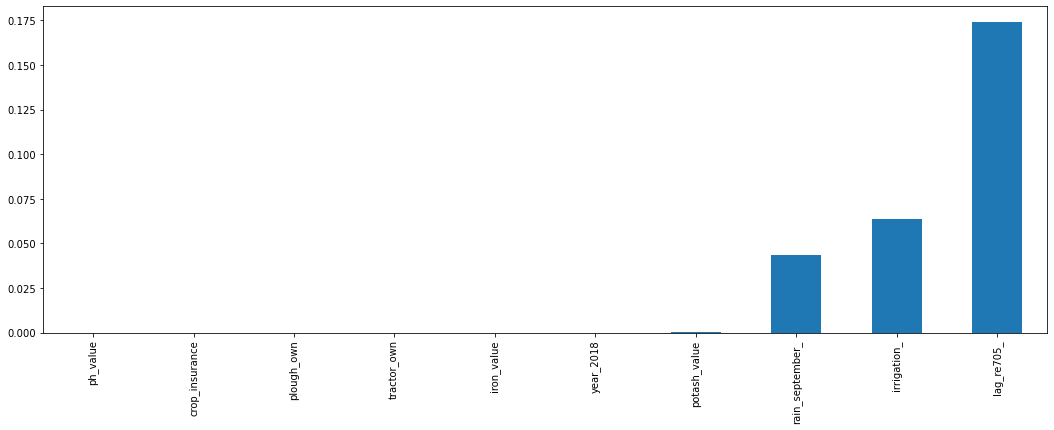

In [5]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

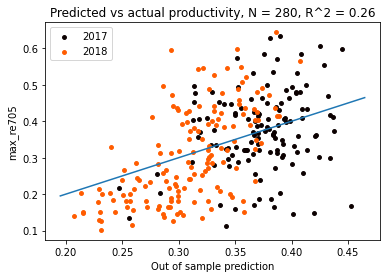

In [6]:
scatter_out_of_sample(e_net)

### Save predictions 

In [7]:
print(full_X.head())
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                 willingness_to_experiment  tractor_own  plough_own  \
id                                                                    
B01V01F00012017                        2.0          0.0         0.0   
B01V01F00012018                        2.0          0.0         0.0   
B01V01F00022017                        2.0          0.0         0.0   
B01V01F00022018                        2.0          0.0         0.0   
B01V01F00042017                        3.0          0.0         0.0   

                 crop_insurance  ph_value  ec_value  nitrogen_value  \
id                                                                    
B01V01F00012017             1.0      7.16      1.36           362.0   
B01V01F00012018             1.0      7.16      1.36           362.0   
B01V01F00022017             1.0      7.87      0.74           334.0   
B01V01F00022018             1.0      7.87      0.74           334.0   
B01V01F00042017             0.0      7.85      0.56           201.0   

    

## Random forest

In [8]:
#Use hyperparameters selected via gridsearchcv in the original yield prediction notebook
hyperparameters = {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 
 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}

rf = RandomForestRegressor(**hyperparameters)
rf.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

Training R^2: 0.85955636179329
Out of sample R^2: 0.43987558057536136


### Feature importances 

In [9]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
lag_re705_              0.099510
rain_september_         0.084545
urea_                   0.080211
rain_july_              0.072002
rain_june_              0.064364
rain_october_           0.063109
potash_value            0.061959
irrigation_             0.053308
rain_august_            0.047662
ec_value                0.040589
nitrogen_value          0.040436
phosphorous_value       0.035768
sulphur_value           0.035077
ph_value                0.034990
sow_time                0.033807
dap_                    0.033765
iron_value              0.033510
soil_test_zinc_value    0.033302
knowledge_              0.017077
year_2018               0.008091


### Scatter plot: predicted vs true value out of sample 

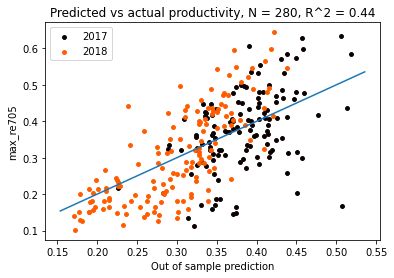

In [10]:
scatter_out_of_sample(rf)

### Save predictions 

In [11]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

## Neural net

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.7204044122468615
Out of sample R^2: 0.16745646961142924


### Scatter plot: predicted vs true value out of sample

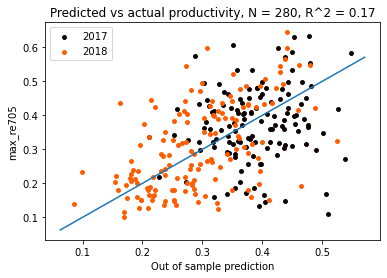

In [13]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'max_re705_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['max_re705_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("max_re705")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [14]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_re705'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

# Satellite measured yields

Second, examine satellite yield measurements. These are just affine transformations of the reNDVI values examined above. However, the transformations are separately estimated from farmer-reported yields in 2017 and 2018, so they may be less consistent across years. 

## Data preparation and imports

In [15]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

raw_df.drop(columns = ['max_re705_', 'yield_hectare_'], inplace=True) 

raw_df.dropna(subset=['satellite_yield_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
# Full DF is what we later generate final predictions off of, so we replace 2018 rainfall with 2017 values
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)
full_df['uid'] = full_df.index.str[:-4]
full_df['year'] = pd.to_numeric(full_df.index.str[-4:])
full_df.loc[full_df['year'] == 2018, 'rain_june_'] = None 
full_df['rain_june_'] = full_df.groupby(['uid'])['rain_june_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_july_'] = None 
full_df['rain_july_'] = full_df.groupby(['uid'])['rain_july_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_august_'] = None 
full_df['rain_august_'] = full_df.groupby(['uid'])['rain_august_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_september_'] = None 
full_df['rain_september_'] = full_df.groupby(['uid'])['rain_september_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_october_'] = None 
full_df['rain_october_'] = full_df.groupby(['uid'])['rain_october_'].ffill()
full_df.drop(columns=['uid', 'year'], inplace=True)
# Since we don't have 2017 data for some plots, there will be missing rainfall. Drop these.
full_df.dropna(subset=['rain_june_'], inplace=True)

# Separate IVs and DVs
y = df[['satellite_yield_']]
X = df.drop(columns=['satellite_yield_'])
full_y = full_df[['satellite_yield_']]
full_X = full_df.drop(columns=['satellite_yield_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [16]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'satellite_yield_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['satellite_yield_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("satellite_yield_")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [17]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 1.14446638
Optimal l1_ratio: 1.000
Number of iterations 29
Training R^2: 0.6308120441632172
Out of sample R^2: 0.6123473197403733


### Feature importance

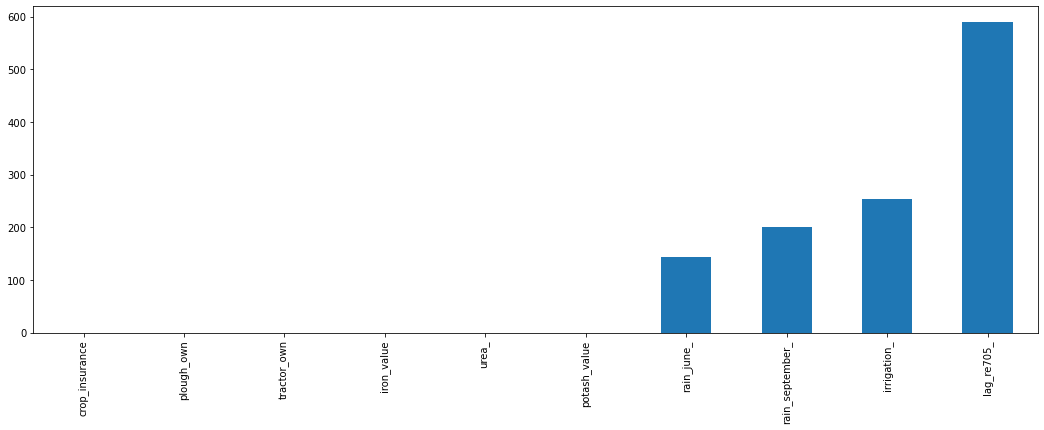

In [18]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

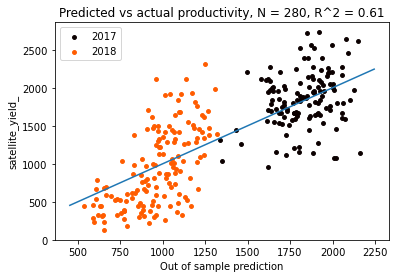

In [19]:
scatter_out_of_sample(e_net)

### Save predictions 

In [20]:
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

## Random forest

In [21]:
#Use hyperparameters selected via gridsearchcv in the original yield prediction notebook
hyperparameters = {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 
                   'min_samples_split': 3, 'n_estimators': 2000}

rf = RandomForestRegressor(**hyperparameters)
rf.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

Training R^2: 0.8965261087696981
Out of sample R^2: 0.7027317358383707


### Feature importances 

In [22]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
rain_july_              0.144432
rain_june_              0.126080
rain_august_            0.117246
rain_september_         0.116116
year_2018               0.090250
rain_october_           0.085371
lag_re705_              0.046770
urea_                   0.044964
irrigation_             0.036952
potash_value            0.028475
ec_value                0.018333
dap_                    0.018057
nitrogen_value          0.017449
phosphorous_value       0.015963
sulphur_value           0.015593
sow_time                0.015250
ph_value                0.014809
soil_test_zinc_value    0.014363
iron_value              0.013792
knowledge_              0.007896


### Scatter plot: predicted vs true value out of sample 

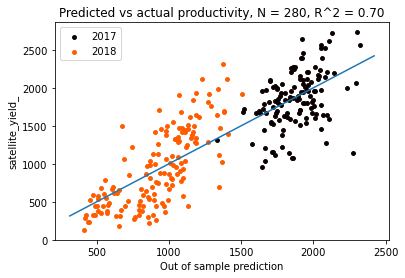

In [23]:
scatter_out_of_sample(rf)

### Save predictions 

In [24]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

## Neural net

In [25]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.683176763424062
Out of sample R^2: 0.5895540066117599


### Scatter plot: predicted vs true value out of sample

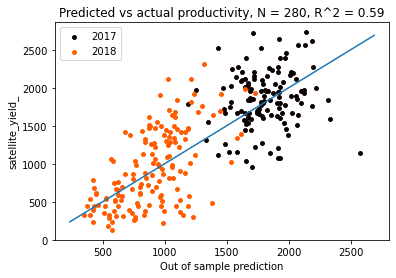

In [26]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'satellite_yield_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['satellite_yield_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("satellite_yield_")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [27]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_satellite_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

# Farmer-reported yields

Thurd, examine satellite yield measurements. 

## Data preparation and imports

In [28]:
raw_df = pd.read_csv('../data/nosync/yield_prediction.csv')
raw_df.set_index('id', inplace=True)

raw_df.drop(columns = ['max_re705_', 'satellite_yield_'], inplace=True)  # Just look at Red-edge NDVI values for now

raw_df.dropna(subset=['yield_hectare_'], inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Copy dataframe, then remove 2018 treatment 
# Full DF is what we later generate final predictions off of, so we replace 2018 rainfall with 2017 values
full_df = df.copy(deep=True)
df.drop(df.loc[raw_df['treatment']==1].index, inplace=True) 
df.drop(columns=['treatment'], inplace=True)
full_df.drop(columns=['treatment'], inplace=True)
full_df['uid'] = full_df.index.str[:-4]
full_df['year'] = pd.to_numeric(full_df.index.str[-4:])
full_df.loc[full_df['year'] == 2018, 'rain_june_'] = None 
full_df['rain_june_'] = full_df.groupby(['uid'])['rain_june_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_july_'] = None 
full_df['rain_july_'] = full_df.groupby(['uid'])['rain_july_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_august_'] = None 
full_df['rain_august_'] = full_df.groupby(['uid'])['rain_august_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_september_'] = None 
full_df['rain_september_'] = full_df.groupby(['uid'])['rain_september_'].ffill()
full_df.loc[full_df['year'] == 2018, 'rain_october_'] = None 
full_df['rain_october_'] = full_df.groupby(['uid'])['rain_october_'].ffill()
full_df.drop(columns=['uid', 'year'], inplace=True)
# Since we don't have 2017 data for some plots, there will be missing rainfall. Drop these.
full_df.dropna(subset=['rain_june_'], inplace=True)

# Separate IVs and DVs
y = df[['yield_hectare_']]
X = df.drop(columns=['yield_hectare_'])
full_y = full_df[['yield_hectare_']]
full_X = full_df.drop(columns=['yield_hectare_'])

# Split data into training and testing samples 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)


In [29]:
# Define a function to plot out of sample predictions vs true values colored by year 
def scatter_out_of_sample(model):
    validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
    predictions = model.predict(X_test)
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={0: 'prediction'}, inplace=True)
    predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'yield_hectare_'}))
    predictions = predictions.join(validate_year_2018)

    year_2018 = [0, 1]
    z = [1, 2]
    hot = plt.get_cmap('hot')
    cNorm = colors.Normalize(vmin=0, vmax=2)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    x = predictions['prediction']
    y = predictions['yield_hectare_']
    
    fig, ax = plt.subplots()

    for i in [0, 1]:
        label = 2017 + i
        indx = predictions['year_2018'] == i
        plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)
    
    _x = np.linspace(*ax.get_xlim())
    ax.plot(_x, _x)

    plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(model, X_test, y_test)))
    plt.xlabel("Out of sample prediction")
    plt.ylabel("yield_hectare_")
    plt.legend(loc='upper left')
    plt.show()

## Elastic net

In [30]:
e_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv.fit(X_train, y_train)

print('Optimal alpha: %.8f'%e_net_cv.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv.l1_ratio_)
print('Number of iterations %d'%e_net_cv.n_iter_)

e_net = ElasticNet(l1_ratio=e_net_cv.l1_ratio_, alpha = e_net_cv.alpha_, 
                        max_iter=e_net_cv.n_iter_, fit_intercept=True, normalize = True)
e_net.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(e_net, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(e_net, X_test, y_test)))

Optimal alpha: 0.16208458
Optimal l1_ratio: 1.000
Number of iterations 171
Training R^2: 0.32779573029669484
Out of sample R^2: 0.36796963781531966


### Feature importance

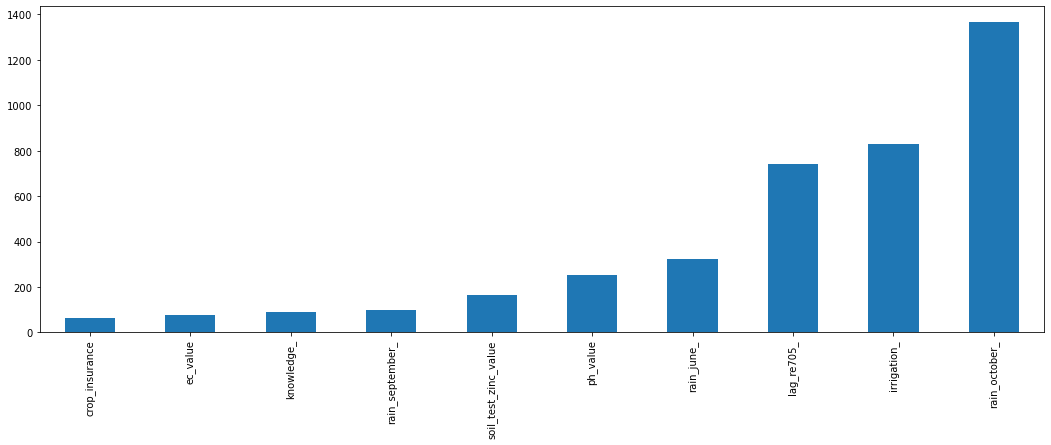

In [31]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))

### Scatter plot: predicted vs true value out of sample 

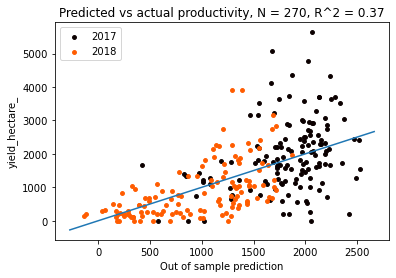

In [32]:
scatter_out_of_sample(e_net)

### Save predictions 

In [33]:
full_sample_predictions = e_net.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['e_net_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

## Random forest

In [34]:
#Use hyperparameters selected via gridsearchcv in the original yield prediction notebook
hyperparameters = {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 
                   'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 500}

rf = RandomForestRegressor(**hyperparameters)
rf.fit(X_train, y_train)

print("Training R^2: {}".format(scoreR2(rf, X_train, y_train)))
print("Out of sample R^2: {}".format(scoreR2(rf, X_test, y_test)))

Training R^2: 0.7187106368251477
Out of sample R^2: 0.40736642949645674


### Feature importances 

In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, 
                                   columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances.head(20))

                      importance
irrigation_             0.103190
urea_                   0.101416
rain_september_         0.075967
rain_june_              0.066220
rain_july_              0.060510
rain_august_            0.056945
sow_time                0.056149
potash_value            0.054826
lag_re705_              0.053566
rain_october_           0.042724
dap_                    0.040164
ec_value                0.038745
ph_value                0.037506
sulphur_value           0.031228
nitrogen_value          0.031197
soil_test_zinc_value    0.030643
phosphorous_value       0.028820
iron_value              0.025987
year_2018               0.019550
knowledge_              0.017434


### Scatter plot: predicted vs true value out of sample 

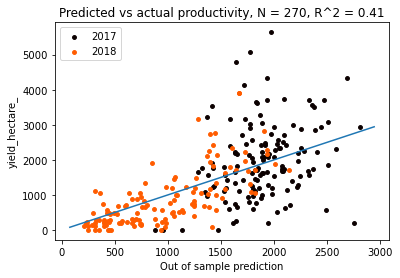

In [36]:
scatter_out_of_sample(rf)

### Save predictions 

In [37]:
full_sample_predictions = rf.predict(full_X)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['rf_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

## Neural net

In [38]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn = MLPRegressor(
    hidden_layer_sizes=(250,250,250,250,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.001, random_state=7)

nn.fit(X_train_sc, y_train)
print("Training R^2: {}".format(scoreR2(nn, X_train_sc, y_train)))
print("Out of sample R^2: {}".format(scoreR2(nn, X_test_sc, y_test)))

Training R^2: 0.4011558134294497
Out of sample R^2: 0.3300245833750609


### Scatter plot: predicted vs true value out of sample

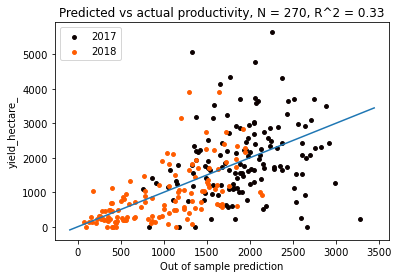

In [39]:
validate_year_2018 = X_test[['year_2018']].reset_index().drop(columns=['id'])
predictions = nn.predict(X_test_sc)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0: 'prediction'}, inplace=True)
predictions = predictions.join(pd.DataFrame(y_test).rename(columns={0: 'yield_hectare_'}))
predictions = predictions.join(validate_year_2018)

year_2018 = [0, 1]
z = [1, 2]
hot = plt.get_cmap('hot')
cNorm = colors.Normalize(vmin=0, vmax=2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

x = predictions['prediction']
y = predictions['yield_hectare_']

fig, ax = plt.subplots()

for i in [0, 1]:
    label = 2017 + i
    indx = predictions['year_2018'] == i
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=label)

_x = np.linspace(*ax.get_xlim())
ax.plot(_x, _x)

plt.title('Predicted vs actual productivity, N = {}, R^2 = {}'.format(len(y_test), '%.2f'%scoreR2(nn, X_test_sc, y_test)))
plt.xlabel("Out of sample prediction")
plt.ylabel("yield_hectare_")
plt.legend(loc='upper left')
plt.show()

### Save predictions

In [40]:
full_X_sc = scaler.transform(full_X)
full_sample_predictions = nn.predict(full_X_sc)
predictions_df = pd.DataFrame(index=full_X.index)
predictions_df['nn_fr_yield'] = full_sample_predictions
results = results.join(predictions_df)
print(results.head())
results.to_csv('../data/nosync/predicted_counterfactual_yields.csv')

                         uid  year  treatment  yield_hectare_2017  \
id                                                                  
B01V01F00012017  B01V01F0001  2017          0           797.59241   
B01V01F00012018  B01V01F0001  2018          0           797.59241   
B01V01F00022017  B01V01F0002  2017          0          2396.62520   
B01V01F00022018  B01V01F0002  2018          0          2396.62520   
B01V01F00042017  B01V01F0004  2017          1          1758.19520   

                 sat_yield_2017  max_re705_2016  max_re705_2017  e_net_re705  \
id                                                                             
B01V01F00012017       1566.7423        0.227357        0.291366     0.370383   
B01V01F00012018       1566.7423        0.227357        0.291366     0.381528   
B01V01F00022017       2100.2913        0.422249        0.448436     0.399262   
B01V01F00022018       2100.2913        0.422249        0.448436     0.403822   
B01V01F00042017       2053.3210     

# Analysis 

We next examine whether there is an expected treatment effect given the predicted yields.

## Reshape results to wide

In [41]:
values = [x for x in results.columns if x not in ['uid', 'year']]
results['year'] = pd.to_numeric(results['year'])
results_wide = results.pivot(index='uid', columns='year', values=values)
results_wide.columns = results_wide.columns.to_flat_index()

years = [2017, 2018]
to_rename = {}
to_drop = []
for x in values:
    #  First process variables that are not constant across years
    if x in ['e_net_re705', 'e_net_satellite_yield', 'e_net_fr_yield',
            'rf_re705', 'rf_satellite_yield', 'rf_fr_yield',
            'nn_re705', 'nn_satellite_yield', 'nn_fr_yield']:
        for y in years:
            to_rename[(x,y)] = x + '_' + str(y)
    #  Second process variables that are constant across years
    else:
        to_rename[(x,years[0])] = x
        to_drop.append((x,years[1]))

results_wide.drop(columns=to_drop, inplace=True)
results_wide.rename(columns=to_rename, inplace=True)

## reNDVI

R[write to console]: Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools

R[write to console]: Loading required namespace: broom.mixed



MODEL INFO:
Observations: 1385 (3 missing obs. deleted)
Dependent Variable: rf_re705_2018
Type: OLS linear regression 

MODEL FIT:
F(3,1381) = 904.32, p = 0.00
R² = 0.66
Adj. R² = 0.66 

Standard errors: Robust, type = HC1
--------------------------------------------------
                       Est.   S.E.   t val.      p
-------------------- ------ ------ -------- ------
(Intercept)            0.21   0.00    48.80   0.00
treatment              0.00   0.00     0.38   0.70
max_re705_2017         0.36   0.01    38.69   0.00
max_re705_2016         0.08   0.01     8.34   0.00
--------------------------------------------------



R[write to console]: Registered S3 methods overwritten by 'broom.mixed':
  method         from 
  augment.lme    broom
  augment.merMod broom
  glance.lme     broom
  glance.merMod  broom
  glance.stanreg broom
  tidy.brmsfit   broom
  tidy.gamlss    broom
  tidy.lme       broom
  tidy.merMod    broom
  tidy.rjags     broom
  tidy.stanfit   broom
  tidy.stanreg   broom



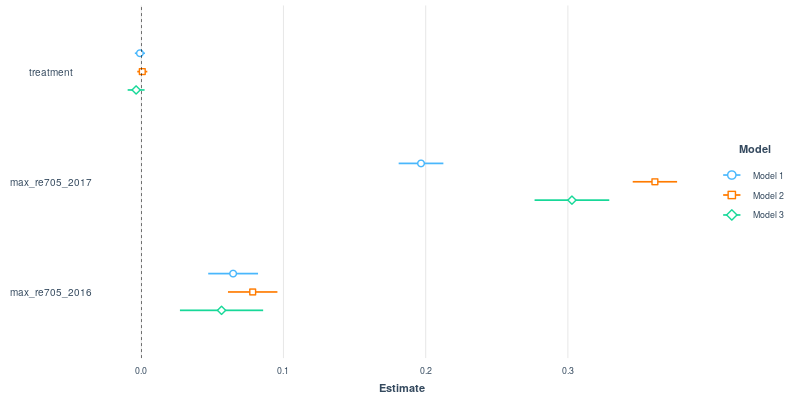

In [42]:
robjects.globalenv['results'] = results_wide
re705_e_net = stats.lm('e_net_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
re705_rf = stats.lm('rf_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
re705_nn = stats.lm('nn_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=base.as_symbol('results'))
print(jtools.summ(re705_rf, robust = "HC1"))  # Print the regression results from the best model

p = jtools.plot_summs(re705_e_net, re705_rf, re705_nn, ci_level = 0.95)  # Plot regression coefficients for each model
image_png(p)

In [43]:
%load_ext rpy2.ipython

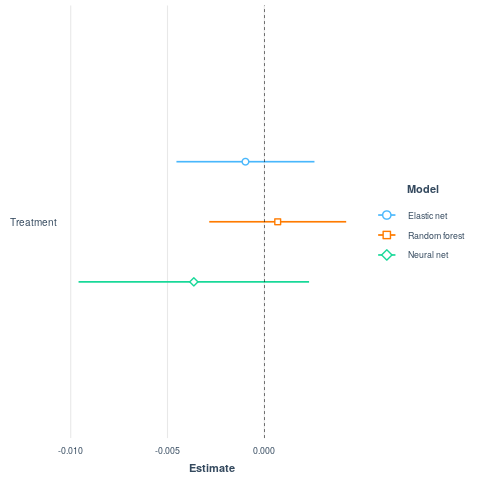

In [44]:
%%R
re705_e_net = lm('e_net_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
re705_rf = lm('rf_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
re705_nn = lm('nn_re705_2018 ~ treatment + max_re705_2017 + max_re705_2016', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(re705_e_net, re705_rf, re705_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))

## Satellite yield

In [45]:
sat_e_net = stats.lm('e_net_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
sat_rf = stats.lm('rf_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
sat_nn = stats.lm('nn_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=base.as_symbol('results'))
print(jtools.summ(sat_rf, robust = "HC1"))  # Print the regression results from the best model

MODEL INFO:
Observations: 1385 (3 missing obs. deleted)
Dependent Variable: rf_satellite_yield_2018
Type: OLS linear regression 

MODEL FIT:
F(3,1381) = 905.84, p = 0.00
R² = 0.66
Adj. R² = 0.66 

Standard errors: Robust, type = HC1
------------------------------------------------------
                          Est.    S.E.   t val.      p
-------------------- --------- ------- -------- ------
(Intercept)            1006.53   16.94    59.43   0.00
treatment                 0.05    5.80     0.01   0.99
sat_yield_2017            0.35    0.01    39.79   0.00
max_re705_2016          213.09   30.36     7.02   0.00
------------------------------------------------------



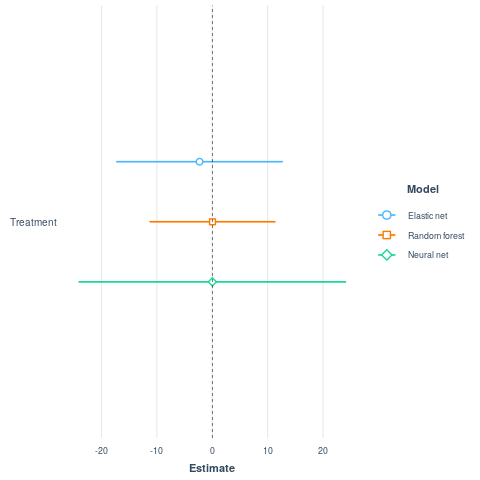

In [46]:
%%R
sat_e_net = lm('e_net_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', results)
sat_rf = lm('rf_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=results)
sat_nn = lm('nn_satellite_yield_2018 ~ treatment + sat_yield_2017 + max_re705_2016', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(sat_e_net, sat_rf, sat_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))

## Farmer-reported yield

In [47]:
fr_e_net = stats.lm('e_net_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
fr_rf = stats.lm('rf_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
fr_nn = stats.lm('nn_fr_yield_2018 ~ treatment + yield_hectare_2017', data=base.as_symbol('results'))
print(jtools.summ(fr_rf, robust = "HC1"))  # Print the regression results from the best model

MODEL INFO:
Observations: 1286 (102 missing obs. deleted)
Dependent Variable: rf_fr_yield_2018
Type: OLS linear regression 

MODEL FIT:
F(2,1283) = 174.66, p = 0.00
R² = 0.21
Adj. R² = 0.21 

Standard errors: Robust, type = HC1
----------------------------------------------------------
                              Est.    S.E.   t val.      p
------------------------ --------- ------- -------- ------
(Intercept)                1293.51   24.30    53.22   0.00
treatment                     8.57   21.21     0.40   0.69
yield_hectare_2017            0.17    0.01    15.21   0.00
----------------------------------------------------------



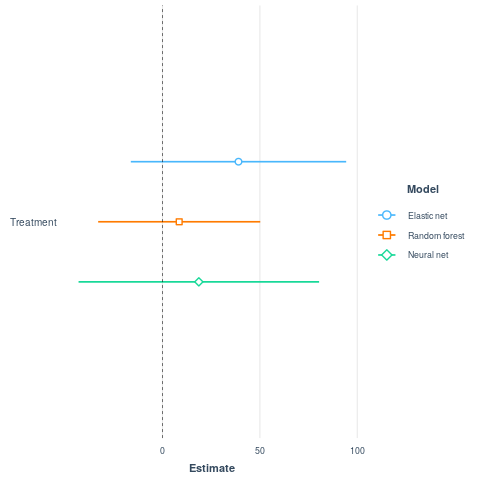

In [48]:
%%R
fr_e_net = lm('e_net_fr_yield_2018 ~ treatment + yield_hectare_2017', results)
fr_rf = lm('rf_fr_yield_2018 ~ treatment + yield_hectare_2017', data=results)
fr_nn = lm('nn_fr_yield_2018 ~ treatment + yield_hectare_2017', data=results)
coefs = c('treatment')
names(coefs) = c('Treatment')
plot_summs(fr_e_net, fr_rf, fr_nn, ci_level = 0.95, coefs=coefs,
          model.names=c('Elastic net', 'Random forest', 'Neural net'))